In [1]:
###Importing packages we need###

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib import cm
from matplotlib.cm import get_cmap
from matplotlib.colors import LinearSegmentedColormap
import metpy.calc as mpcalc
from metpy.units import units
from matplotlib.lines import Line2D
from numpy import *
import xarray as xr
from netCDF4 import Dataset, num2date
import math
import pygrib
import matplotlib.patches as patches
import cdsapi
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
import metpy as mp
import os
import warnings
warnings.filterwarnings("ignore")

print("Done importing modules")

Done importing modules


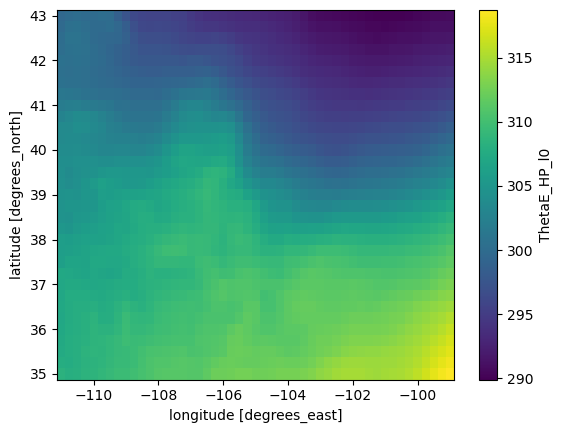

In [2]:
test = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/thetaE_SD.nc')
test['ThetaE_HP_l0'].plot()

In [3]:
###Import the 3 CF tables and concatenate###

#Read in the 3 tables#
dfg = pd.read_csv('/projects/zami4053/Synoptic_Research/CSV_DFs/CF_good.csv')
dfmf = pd.read_csv('/projects/zami4053/Synoptic_Research/CSV_DFs/CF_mf_updated.csv')
dfu = pd.read_csv('/projects/zami4053/Synoptic_Research/CSV_DFs/CF_unclear_updated_new.csv')
                  
#Combine into 1 big file with all CF cases and reset index#
dfall = pd.concat([dfg, dfmf, dfu])
dfall.reset_index(drop=True, inplace=True)
#dfall

#Sort the DataFrame by 'date' and del duplicate#
dfall_sort = dfall.sort_values(by='date').reset_index(drop=True)
dfall_sort = dfall_sort.drop(260)
dfall_sort = dfall_sort.sort_values(by='date').reset_index(drop=True)
dfall_sort

#Organize by Low and High Precipitation Events#
df_LP = pd.read_csv('/projects/zami4053/Synoptic_Research/CSV_DFs/CF_Low_Precip.csv')
df_HP = pd.read_csv('/projects/zami4053/Synoptic_Research/CSV_DFs/CF_High_Precip.csv')

df_select = df_LP.copy()
df_select

,date,max_value,max_time,file_date,total_precip
0,1950-11-02,625.744615,1950-11-01 10:00:00,1950-11-02,0.039172
1,1950-12-27,1011.129758,1950-12-26 15:00:00,1950-12-27,61.792616
2,1951-01-28,2451.093687,1951-01-27 05:00:00,1951-01-28,4.875601
3,1951-03-09,5164.179325,1951-03-08 09:00:00,1951-03-09,9.902985
4,1951-03-24,2864.818543,1951-03-23 08:00:00,1951-03-24,13.509710
...,...,...,...,...,...
140,2021-11-01,672.486578,2021-10-31 06:00:00,2021-11-01,15.182394
141,2021-11-09,393.261911,2021-11-09 02:00:00,2021-11-09,9.922114
142,2021-11-18,3125.050762,2021-11-17 10:00:00,2021-11-18,62.295407
143,2021-12-07,10677.291980,2021-12-06 01:00:00,2021-12-07,7.024482


In [4]:
###Extract the max times so we can use them for compositing###

#Pull out the max time column#
max_times = list(df_select['max_time'].values)
dates = list(df_select['date'].values)
N = len(max_times)

max_times[0:10], print(N)

145


(['1950-11-01 10:00:00',
  '1950-12-26 15:00:00',
  '1951-01-27 05:00:00',
  '1951-03-08 09:00:00',
  '1951-03-23 08:00:00',
  '1951-09-11 12:00:00',
  '1951-10-15 14:00:00',
  '1951-10-30 17:00:00',
  '1953-01-28 01:00:00',
  '1953-10-03 08:00:00'],
 None)

In [5]:
###Example of one of the data files to see the variables###

testing1 = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_Comp_largedomain/single_level_vars/ThetaE_LD/ERA5_sl_thetaE_LD_01_01_2011.nc')
#testing1

testing2 = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_Climos_LD/Climos_pl_LD_vars/climatology_LD_sl_1950-01-01 00:00:00.nc')
testing2.sel(pressure_level=[250]).squeeze(dim='pressure_level', drop=True)

testing3 = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_Comp_largedomain/pressure_level_vars/pl_temps_omega/ERA5_pl_temps_omega_01_01_2011.nc')
testing3.sel(level=[850]).squeeze(dim='level', drop=True)

testing4 = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/CF_Comp_largedomain/pressure_level_vars/pl_winds/ERA5_pl_winds_01_01_2011.nc')
testing4.sel(level=[250]).squeeze(dim='level', drop=True)

#Test for the Cross Section files#
testing5 = xr.open_dataset('/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/Vert_CS_Data/ERA5_vertCS_01_01_2011.nc')
testing5


<xarray.Dataset>
Dimensions:         (valid_time: 288, pressure_level: 27, latitude: 17,
                     longitude: 17)
Coordinates:
  * valid_time      (valid_time) datetime64[ns] 2010-01-01 ... 2011-12-31T23:...
  * pressure_level  (pressure_level) float64 1e+03 975.0 950.0 ... 125.0 100.0
  * latitude        (latitude) float64 41.0 40.75 40.5 40.25 ... 37.5 37.25 37.0
  * longitude       (longitude) float64 -106.0 -105.8 -105.5 ... -102.2 -102.0
Data variables:
    number          int64 ...
    expver          (valid_time) object ...
    r               (valid_time, pressure_level, latitude, longitude) float32 ...
    t               (valid_time, pressure_level, latitude, longitude) float32 ...
    u               (valid_time, pressure_level, latitude, longitude) float32 ...
    v               (valid_time, pressure_level, latitude, longitude) float32 ...
    w               (valid_time, pressure_level, latitude, longitude) float32 ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-12-26T08:10 GRIB to CDM+CF via cfgrib-0.9.1...

In [ ]:
##Make a function to calculate both Theta###

#Calculate ThetaE or Theta at every gridpoint for every timestep#
def calculate_ThetaE(ds_sfc):
    '''Takes in an xr and uses dewpoint, temperature, and pressure to calculate ThetaE.
    
    Parameters:
    - ds_sfc: An xarray dataframe containing the 3 variables needed to calculate ThetaE  
    '''
    
    #Area and Times#
    colorado_area = [41, -106, 37, -102]  #Buffer on all sides
    latN = 41
    latS = 37
    lonW = -106   #Must be in degrees E 
    lonE = -102    #Must be in degrees E 
    level = 850    
    
    #This is for the surface level variables#
    dew_2m = ds_sfc.d2m.metpy.sel(latitude=slice(latN,latS),longitude=slice(lonW,lonE))
    tmpk_2m = ds_sfc.t2m.metpy.sel(latitude=slice(latN,latS),longitude=slice(lonW,lonE))
    sfc_p = ds_sfc.sp.metpy.sel(latitude=slice(latN,latS),longitude=slice(lonW,lonE))

    #Extract Coordinates#
    global dx, dy   #need to use these for other steps
    lats = ds_sfc.latitude.metpy.sel(latitude=slice(latN,latS))
    lons = ds_sfc.longitude.metpy.sel(longitude=slice(lonW,lonE))
    lons_2D, lats_2D = meshgrid(lons,lats)
    dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
    
    #Smooth the surface variables for synoptic features#
    smoothing_var = 0

    dew_2m = mpcalc.smooth_gaussian(dew_2m, smoothing_var)
    tmpk_2m = mpcalc.smooth_gaussian(tmpk_2m, smoothing_var)
    sfc_p = mpcalc.smooth_gaussian(sfc_p, smoothing_var)
    
    #Calculate ThetaE#
    thetaE = mpcalc.equivalent_potential_temperature(sfc_p, tmpk_2m, dew_2m) 
    
    return thetaE


def calculate_Theta(ds_sfc):
    '''Takes in an xr and uses temperature and pressure to calculate Theta.
    
    Parameters:
    - ds_sfc: An xarray dataframe containing the 2 variables needed to calculate ThetaE  
    '''
    
    #Area and Times#
    colorado_area = [41, -106, 37, -102]  #Buffer on all sides
    latN = 41
    latS = 37
    lonW = -106   #Must be in degrees E 
    lonE = -102    #Must be in degrees E 
    level = 850    
    
    #This is for the surface level variables#
    tmpk_2m = ds_sfc.t.metpy.sel(latitude=slice(latN,latS),longitude=slice(lonW,lonE))
    sfc_p = 1000 * units("hPa")

    #Extract Coordinates#
    global dx, dy   #need to use these for other steps
    lats = ds_sfc.latitude.metpy.sel(latitude=slice(latN,latS))
    lons = ds_sfc.longitude.metpy.sel(longitude=slice(lonW,lonE))
    lons_2D, lats_2D = meshgrid(lons,lats)
    dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)
    
    #Smooth the surface variables for synoptic features#
    smoothing_var = 0

    tmpk_2m = mpcalc.smooth_gaussian(tmpk_2m, smoothing_var)
    
    #Calculate Theta#
    theta = mpcalc.potential_temperature(sfc_p, tmpk_2m) 
    
    return theta


def calculate_Theta_3d(ds):
    '''
    Calculates Theta (potential temperature) for all pressure levels dynamically.

    Parameters:
    - ds: An xarray dataset containing temperature and pressure variables.
    Returns:
    - theta: A 4D array (time, pressure_level, latitude, longitude) of potential temperature.
    '''
    #Define the geographic area of interest#
    colorado_area = [41, -106, 37, -102]  
    latN, lonW, latS, lonE = colorado_area

    #Extract temperature and pressure data for all levels#
    tmpk = ds['t'].metpy.sel(latitude=slice(latN, latS), longitude=slice(lonW, lonE))
    pressure_levels = ds['pressure_level'] * units("hPa")

    #Extract latitude and longitude coordinates#
    lats = ds['latitude'].sel(latitude=slice(latN, latS))
    lons = ds['longitude'].sel(longitude=slice(lonW, lonE))
    global dx, dy 
    dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

    #Smooth the temperature field for synoptic features#
    smoothing_var = 0
    
    if smoothing_var > 0:
        tmpk = mpcalc.smooth_gaussian(tmpk, smoothing_var)

    #Calculate Theta for each pressure level#
    theta = mpcalc.potential_temperature(pressure_levels[:], tmpk)

    return theta

#Test plot the thetaE or Theta values#
theta_test = calculate_Theta_3d(testing5)

theta_testy = theta_test.isel(valid_time=10, longitude=9, latitude=9)
theta_testy

In [ ]:
###Fix the lists###

dates_as_strings = [str(date).split('T')[0] for date in dates]
dates_as_strings[0:5]

In [ ]:
###Now try compositing accross all 27 pressure levels simulataneously###

def composite_average_3d(data_folder, date_list, time_list, variable, lat_range, lon_range, time_lag=0, anom=False):
    """
    Calculates the composite average 3D map (latitude, longitude, pressure level) for the specified variable and domain.

    Parameters:
    - data_folder: Path to the folder containing the data files.
    - date_list: List of datetime strings in the format 'YYYY-MM-DD HH:MM:SS'.
    - variable: The variable to be analyzed
    - lat_range: Tuple specifying the latitude range (min_lat, max_lat).
    - lon_range: Tuple specifying the longitude range (min_lon, max_lon).
    - time_lag: Time lag in hours to be applied (default is 0).
    """
    def datetime_to_filename(date_str):
        
        date = datetime.strptime(date_str, '%Y-%m-%d')
        
        return f'ERA5_vertCS_{date.month:02d}_{date.day:02d}_{date.year}.nc'

    sample_file = os.path.join(data_folder, datetime_to_filename(date_list[0]))
    sample_data = xr.open_dataset(sample_file)

    lat = sample_data['latitude']
    lon = sample_data['longitude']
    pressure_levels = sample_data['pressure_level']

    lat_indices = np.where((lat >= lat_range[0]) & (lat <= lat_range[1]))[0]
    lon_indices = np.where((lon >= lon_range[0]) & (lon <= lon_range[1]))[0]

    composite_data = np.empty((len(date_list), len(pressure_levels), len(lat_indices), len(lon_indices)))
    
    #Loop through and select the correct t=0 time#
    for i, (date_str, time_str) in enumerate(zip(date_list, time_list)):
        filename = datetime_to_filename(date_str)
        file_path = os.path.join(data_folder, filename)
        data = xr.open_dataset(file_path)

        target_time = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S') + timedelta(hours=time_lag)
        time_idx = np.argmin(np.abs(data['valid_time'].values - np.datetime64(target_time)))
        selected_time = data['valid_time'].values[time_idx]
        
        #Need to loop through all vertical pressure levels#
        for j, pressure_level in enumerate(pressure_levels):
            var_data = data[variable].sel(
                valid_time=selected_time,
                pressure_level=pressure_level
            ).isel(latitude=lat_indices, longitude=lon_indices)
            
            #Store the 3d composited data#
            composite_data[i, j, :, :] = var_data

    composite_avg = np.mean(composite_data, axis=0)

    print("Done Compositing!")

    return composite_avg, composite_data

#Calling the function#
data_folder = '/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/Vert_CS_Data/'    #may have to edit
date_list = dates_as_strings.copy()
time_list = max_times.copy()
variable = 't'                #any variable in xr (thetaE, FLF too)
lat_range = (37, 41)          #Latitude range (min_lat, max_lat): state of CO with 1 deg buffer #35,43  / 10,80
lon_range = (-106, -102)        #Longitude range (min_lon, max_lon): state of CO with 1 deg buffer  #-110,-100  / 100,280
time_lag = 0               #Can either be 0 or negative numbers

composite_avg_3d, composite_data_3d = composite_average_3d(data_folder, date_list, time_list, variable, lat_range, lon_range, time_lag, anom=False)

In [ ]:
composite_data_3d.shape

In [ ]:
def composite_average_3d_theta(data_folder, date_list, time_list, variable, lat_range, lon_range, time_lag=0, anom=False):
    """
    Calculates the composite average 3D map (latitude, longitude, pressure level) for the specified variable and domain.

    Parameters:
    - data_folder: Path to the folder containing the data files.
    - date_list: List of datetime strings in the format 'YYYY-MM-DD HH:MM:SS'.
    - variable: The variable to be analyzed, or 'theta' for potential temperature.
    - lat_range: Tuple specifying the latitude range (min_lat, max_lat).
    - lon_range: Tuple specifying the longitude range (min_lon, max_lon).
    - time_lag: Time lag in hours to be applied (default is 0).
    """
    def datetime_to_filename(date_str):
        date = datetime.strptime(date_str, '%Y-%m-%d')
        return f'ERA5_vertCS_{date.month:02d}_{date.day:02d}_{date.year}.nc'

    sample_file = os.path.join(data_folder, datetime_to_filename(date_list[0]))
    sample_data = xr.open_dataset(sample_file)
    
    lat = sample_data['latitude']
    lon = sample_data['longitude']
    pressure_levels = sample_data['pressure_level']

    lat_indices = np.where((lat >= lat_range[0]) & (lat <= lat_range[1]))[0]
    lon_indices = np.where((lon >= lon_range[0]) & (lon <= lon_range[1]))[0]

    composite_data = np.empty((len(date_list), len(pressure_levels), len(lat_indices), len(lon_indices)))

    #Loop through and select the correct t=0 time#
    for i, (date_str, time_str) in enumerate(zip(date_list, time_list)):
        filename = datetime_to_filename(date_str)
        file_path = os.path.join(data_folder, filename)
        data = xr.open_dataset(file_path)

        target_time = datetime.strptime(time_str, '%Y-%m-%d %H:%M:%S') + timedelta(hours=time_lag)
        time_idx = np.argmin(np.abs(data['valid_time'].values - np.datetime64(target_time)))
        selected_time = data['valid_time'].values[time_idx]

        if variable == 'theta':
            #Dynamically calculate theta for all pressure levels#
            ds_subset = data.sel(
                valid_time=selected_time,
                latitude=slice(lat_range[1], lat_range[0]),  
                longitude=slice(lon_range[0], lon_range[1])
            )
            
            theta = calculate_Theta_3d(ds_subset)
            composite_data[i, :, :, :] = theta.values  #Assign all levels at once
       
        else:
            #Loop through all vertical pressure levels for other variables#
            for j, pressure_level in enumerate(pressure_levels):
                
                var_data = data[variable].sel(
                    valid_time=selected_time,
                    pressure_level=pressure_level
                ).isel(latitude=lat_indices, longitude=lon_indices)
                
                #Store the 3D composited data#
                composite_data[i, j, :, :] = var_data

    composite_avg = np.mean(composite_data, axis=0)

    print("Done Compositing!")

    return composite_avg, composite_data, lat, lon

#Calling the function#
data_folder2 = '/pl/active/ATOC_SynopticMet/Michael/ERA5_CF_cases/Vert_CS_Data/'    #may have to edit
date_list2 = dates_as_strings.copy()
time_list2 = max_times.copy()
variable2 = 'r'                #any variable in xr (thetaE, FLF too)
lat_range2 = (37, 41)          #Latitude range (min_lat, max_lat): state of CO with 1 deg buffer #35,43  / 10,80
lon_range2 = (-106, -102)        #Longitude range (min_lon, max_lon): state of CO with 1 deg buffer  #-110,-100  / 100,280
time_lag2 = 0               #Can either be 0 or negative numbers

composite_avg_3d_theta, composite_data_3d_theta, lat_3d, lon_3d = composite_average_3d_theta(data_folder2, date_list2, time_list2, variable2, lat_range2, lon_range2, time_lag2, anom=False)

In [ ]:
composite_avg_3d_theta.shape

In [ ]:
###Save this variables###

#Cross sections#
#theta_LP_l0 = composite_avg_3d_theta.copy()
#t_LP_l0 = composite_avg_3d_theta.copy()
#u_LP_l0 = composite_avg_3d_theta.copy()
#v_LP_l0 = composite_avg_3d_theta.copy()
#w_LP_l0 = composite_avg_3d_theta.copy()
# rh_LP_l0 = composite_avg_3d_theta.copy()

# #Specify the dimensions to save#
# lat = lat_3d 
# lon = lon_3d
# pressure = testing5['pressure_level']

# #Create DataArrays with explicit dimensions for each variable#
# rh_LP_l0 = xr.DataArray(rh_LP_l0, dims=["pressure_level", "latitude", "longitude"], coords={"pressure_level":pressure, "latitude": lat, "longitude": lon})

# #Combine them into a Dataset#
# ds_now = xr.Dataset({
#     'rh_LP_l0': rh_LP_l0,
# })

# #Save the dataset to a NetCDF file#
# ds_now.to_netcdf('rh_LP_l0.nc')


In [ ]:
hio = xr.open_dataset('t_HP_l0.nc')
hio

In [ ]:
###Plot the composite map for Colorado Region###

#Specify a variable and units to plot#
var_of_interest = 'Temperature'
unit_of_interest = 'K'

#Set up the projection that will be used#
mapcrs = ccrs.LambertConformal(central_longitude=-55, central_latitude=45, standard_parallels=(33, 45)) 
mapcrs = ccrs.PlateCarree()

#Set up the projection of the data; if lat/lon then PlateCarree is what you want#
datacrs = ccrs.PlateCarree()

#Start the figure and create plot axes with proper projection#
fig = plt.figure(1, figsize=(12, 12)) 
ax = plt.subplot(111, projection=mapcrs) 
ax.set_extent([-109, -102, 37, 41], ccrs.PlateCarree())  #-110, -100, 35, 43 

#Add geopolitical boundaries for map reference#
ax.add_feature(cfeature.LAND, facecolor="white") 
countries = NaturalEarthFeature(category="cultural", scale="110m", facecolor="none", name="admin_0_boundary_lines_land") 
ax.add_feature(countries, linewidth=0.5, edgecolor="black") 
ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5) 
ax.coastlines('50m', linewidth=0.8)

#Add the fcontours#
#temp_levels = np.arange(264, 289, 0.5)
#mslp_levels = np.arange(1004, 1025, 1)
#u_v_levels = np.arange(-8, 4.5, 0.5)
#thetaE_levels = np.arange(288, 313, 1)
#omega_levels = np.arange(-1, 1.05, 0.05)
temp_comp_cf = plt.contourf(lon_3d, lat_3d, composite_avg_3d_theta[1,:,:], levels=None, cmap="bwr", alpha=1, transform=ccrs.PlateCarree(), label="2-m Temp")

#Colorbar and contour labels#
cb = fig.colorbar(temp_comp_cf, orientation='horizontal', pad=0.08, extendrect=True, aspect=20, shrink=1)
cb.set_label(f'{var_of_interest} [{unit_of_interest}]', size='x-large') #FLF [K/m^3 * 10^14]

#Fix the lats and lon values#
ax.set_xticks(range(-109, -102, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(37, 41, 1), crs=ccrs.PlateCarree())
x_ticks = [-110,-108,-106,-104,-102,-100]
x_tick_labels = ['-110°','-108°','-106°','-104°','-102°','-100°']
y_ticks = [35,37,39,41,43]
y_tick_labels = ['35°','37°','39°','41°','43°']
plt.xticks(x_ticks, x_tick_labels)
plt.yticks(y_ticks, y_tick_labels)
ax.tick_params(axis='both', which='major', labelsize=14)

#Plot the longitude and latitude#
ax.set_xticks(range(-110, -99, 1), crs=ccrs.PlateCarree())
ax.set_yticks(range(35, 44, 1), crs=ccrs.PlateCarree())
ax.set_xlabel('Longitude', fontsize=14)
ax.set_ylabel('Latitude', fontsize=14)
plt.title(f'Composited {var_of_interest} [{unit_of_interest}] for timelag=0', fontsize=16) 

plt.show()

In [6]:
###Import all the CS data for plotting###

rh_HP_l0 = xr.open_dataset('/projects/zami4053/Synoptic_Research/CS_Netcdfs/rh_HP_l0.nc')
rh_LP_l0 = xr.open_dataset('/projects/zami4053/Synoptic_Research/CS_Netcdfs/rh_LP_l0.nc')
t_HP_l0 = xr.open_dataset('/projects/zami4053/Synoptic_Research/CS_Netcdfs/t_HP_l0.nc')
t_LP_l0 = xr.open_dataset('/projects/zami4053/Synoptic_Research/CS_Netcdfs/t_LP_l0.nc')
theta_HP_l0 = xr.open_dataset('/projects/zami4053/Synoptic_Research/CS_Netcdfs/theta_HP_l0.nc')
theta_LP_l0 = xr.open_dataset('/projects/zami4053/Synoptic_Research/CS_Netcdfs/theta_LP_l0.nc')
u_HP_l0 = xr.open_dataset('/projects/zami4053/Synoptic_Research/CS_Netcdfs/u_HP_l0.nc')
u_LP_l0 = xr.open_dataset('/projects/zami4053/Synoptic_Research/CS_Netcdfs/u_LP_l0.nc')
v_HP_l0 = xr.open_dataset('/projects/zami4053/Synoptic_Research/CS_Netcdfs/v_HP_l0.nc')
v_LP_l0 = xr.open_dataset('/projects/zami4053/Synoptic_Research/CS_Netcdfs/v_LP_l0.nc')
w_HP_l0 = xr.open_dataset('/projects/zami4053/Synoptic_Research/CS_Netcdfs/w_HP_l0.nc')
w_LP_l0 = xr.open_dataset('/projects/zami4053/Synoptic_Research/CS_Netcdfs/w_LP_l0.nc')
mslpraw_df = xr.open_dataset('/projects/zami4053/Synoptic_Research/Composite_NetCDFs/MSLPraw_SD.nc')
t_LP_l0

<xarray.Dataset>
Dimensions:         (pressure_level: 27, latitude: 17, longitude: 17)
Coordinates:
  * pressure_level  (pressure_level) float64 1e+03 975.0 950.0 ... 125.0 100.0
  * latitude        (latitude) float64 41.0 40.75 40.5 40.25 ... 37.5 37.25 37.0
  * longitude       (longitude) float64 -106.0 -105.8 -105.5 ... -102.2 -102.0
Data variables:
    t_LP_l0         (pressure_level, latitude, longitude) float64 ...

In [7]:
###Use temperature and rh to calculate dewpoint and then ThetaE###

#Convert Temperature to Celsius and RH to Fraction#
temperature_C = (t_LP_l0['t_LP_l0'].values * units.K).to('degC')  
relative_humidity = rh_LP_l0['rh_LP_l0'].values / 100.0  

#Compute Dewpoint#
dewpoint = np.empty_like(temperature_C) * units.degC 

for i in range(temperature_C.shape[0]):  #Loop over 27 pressure levels
    dewpoint[i] = mpcalc.dewpoint_from_relative_humidity(temperature_C[i], relative_humidity[i])

#Convert Temperature Back to Kelvin for ThetaE Calculation#
temperature_K = temperature_C.to('K')  

#Reshape Pressure Levels to Match Temperature Shape#
pressure_levels_hPa = theta_LP_l0['pressure_level'].values[:, np.newaxis, np.newaxis] * units.hPa  

#Compute Equivalent Potential Temperature#
theta_E = np.empty_like(temperature_K) * units.K 

for i in range(temperature_K.shape[0]):  #Loop over 27 pressure levels
    theta_E[i] = mpcalc.equivalent_potential_temperature(pressure_levels_hPa[i], temperature_K[i], dewpoint[i])

##Convert to xr##

#Define dimensions#
pressure_levels = theta_LP_l0['pressure_level'].values 
latitudes = theta_LP_l0['latitude'].values  
longitudes = theta_LP_l0['longitude'].values  

#Make the xr#
theta_E_xr = xr.DataArray(
    theta_E.magnitude,  
    coords={"pressure_level": pressure_levels, "latitude": latitudes, "longitude": longitudes},
    dims=["pressure_level", "latitude", "longitude"],  # Define dimension order
    attrs={"units": "K", "description": "Equivalent Potential Temperature (Theta-E)"},
)

theta_E_ds = xr.Dataset({"theta_E": theta_E_xr})
theta_E_ds

<xarray.Dataset>
Dimensions:         (pressure_level: 27, latitude: 17, longitude: 17)
Coordinates:
  * pressure_level  (pressure_level) float64 1e+03 975.0 950.0 ... 125.0 100.0
  * latitude        (latitude) float64 41.0 40.75 40.5 40.25 ... 37.5 37.25 37.0
  * longitude       (longitude) float64 -106.0 -105.8 -105.5 ... -102.2 -102.0
Data variables:
    theta_E         (pressure_level, latitude, longitude) float64 308.0 ... 3...

In [8]:
###Extract the data for the CS###

#Extract the index of the longitude of interest#
lon_index = 12   #corresponds to -103

#Extract data for the cross-section at -103°W for all vars#
CS_rh_HP = rh_HP_l0.sel(longitude=-103)
CS_t_HP = t_HP_l0.sel(longitude=-103)
CS_theta_HP = theta_HP_l0.sel(longitude=-103)
CS_u_HP = u_HP_l0.sel(longitude=-103)
CS_v_HP = v_HP_l0.sel(longitude=-103)
CS_w_HP = w_HP_l0.sel(longitude=-103)
CS_press_HP = mslpraw_df['MSLPraw_HP_l0'].sel(latitude=slice(41,37)).sel(longitude=257)
CS_thetaE_HP = None

CS_rh_LP = rh_LP_l0.sel(longitude=-103)
CS_t_LP = t_LP_l0.sel(longitude=-103)
CS_theta_LP = theta_LP_l0.sel(longitude=-103)
CS_u_LP = u_LP_l0.sel(longitude=-103)
CS_v_LP = v_LP_l0.sel(longitude=-103)
CS_w_LP = w_LP_l0.sel(longitude=-103)
CS_thetaE_LP = theta_E_ds.sel(longitude=-103)
CS_press_LP = mslpraw_df['MSLPraw_LP_l0'].sel(latitude=slice(41,37)).sel(longitude=257)

CS_press_LP.values / 100 - 150
CS_u_LP

<xarray.Dataset>
Dimensions:         (pressure_level: 27, latitude: 17)
Coordinates:
  * pressure_level  (pressure_level) float64 1e+03 975.0 950.0 ... 125.0 100.0
  * latitude        (latitude) float64 41.0 40.75 40.5 40.25 ... 37.5 37.25 37.0
    longitude       float64 -103.0
Data variables:
    u_LP_l0         (pressure_level, latitude) float64 ...

In [9]:
###Calculate fgen at all pressure levels###

#Lats and lons#
lats = t_LP_l0['t_LP_l0'].latitude.values
lons = t_LP_l0['t_LP_l0'].longitude.values
dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

#Convert data to MetPy units#
temperature = t_LP_l0['t_LP_l0'].values * units.degK  #Temperature in Kelvin
u_wind = u_LP_l0['u_LP_l0'].values * units('m/s')     #u-component of wind
v_wind = v_LP_l0['v_LP_l0'].values * units('m/s')     #v-component of wind

#Initialize an array to store frontogenesis at all pressure levels#
pressure_levels = t_LP_l0['pressure_level'].values  
frontogenesis_all_levels = np.empty_like(temperature) 

#Iterate over each pressure level#
for i, level in enumerate(pressure_levels):

    thetaE_level = theta_E_ds['theta_E'][i, :, :].values * units.degK  #ThetaE
    u_level = u_wind[i, :, :]
    v_level = v_wind[i, :, :]
    
    #Calculate frontogenesis at this level#
    frontogenesis_o = mpcalc.frontogenesis(thetaE_level, u_level, v_level, dx=dx, dy=dy)
    
    #Smooth the frontogenesis field#
    frontogenesis_smoothed = mpcalc.smooth_gaussian(frontogenesis_o, n=15)
    
    #Store the smoothed frontogenesis in the array#
    frontogenesis_all_levels[i, :, :] = frontogenesis_smoothed

#Convert frontogenesis to appropriate units#
frontogenesis_all_levels *= 1e9  

#Check min and max values across all levels#
min_fgen = np.nanmin(frontogenesis_all_levels)
max_fgen = np.nanmax(frontogenesis_all_levels)
#min_fgen, max_fgen

frontogenesis_all_levels[:, :,0].shape

(27, 17)

In [10]:
np.max(frontogenesis_all_levels[:, :,0])

8.009330545447229

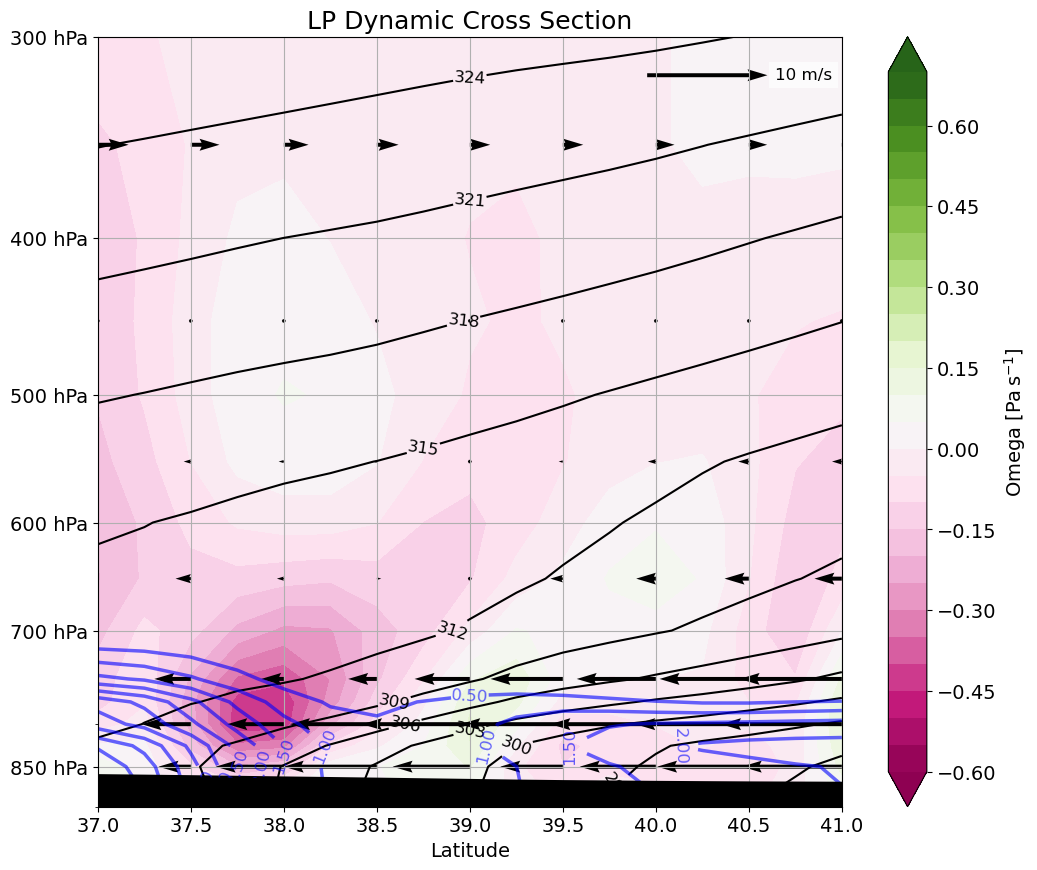

In [34]:
###Plot a vertical cross section for dynamics###

#Plot the vertical cross-section#
fig, ax = plt.subplots(figsize=(12, 10))

#Define contour levels for omega#
omega_levels = np.arange(-0.6, 0.75, 0.05) 
fgen_levels = np.arange(0.5, 9, 0.5) 

#ThetaE contours#
cf = ax.contour(CS_thetaE_LP['latitude'], CS_thetaE_LP['pressure_level'], CS_thetaE_LP['theta_E'], 
                levels=40, colors='black', linewidths=1.5)  # Theta
ax.clabel(cf, inline=True, fontsize=12, fmt='%1.0f') 

#Omega contours#
cf2 = ax.contourf(CS_w_LP['latitude'], CS_w_LP['pressure_level'], CS_w_LP['w_LP_l0'], 
                 levels=omega_levels, cmap="PiYG", extend="both")  

#Fgen contours#
cf3 = ax.contour(CS_press_LP['latitude'], CS_w_LP['pressure_level'], frontogenesis_all_levels[:, :, 0], 
                 levels=fgen_levels, colors='blue', extend="both", linewidths=2.5, alpha=0.6)  
ax.clabel(cf3, inline=True, fontsize=12, fmt='%1.2f') 

##Wind barbs plotting##

u_wind = CS_u_LP['u_LP_l0'].values * 0
v_wind = CS_v_LP['v_LP_l0'].values  
latitudes = CS_u_LP['latitude'].values  
pressure_levels = CS_u_LP['pressure_level'].values

#Downsample for readability#
lat_index = np.arange(0, len(latitudes), 2) 
pres_index = np.arange(0, len(pressure_levels), 2) 
lat_grid, pres_grid = np.meshgrid(latitudes[lat_index], pressure_levels[pres_index])

u_subset = u_wind[np.ix_(pres_index, lat_index)]  
v_subset = v_wind[np.ix_(pres_index, lat_index)] 

#Plot wind barbs on the cross-section#
# ax.barbs(lat_grid, pres_grid, v_subset, u_subset, 
#         length=6, linewidth=1, barb_increments={'half': 2.5, 'full': 5, 'flag': 25}
# )  
Q = ax.quiver(lat_grid, pres_grid, v_subset, u_subset, linewidth=0.5)
ax.quiverkey(Q, X=0.9, Y=0.95, U=10, label=None, labelpos='E')
ax.text(0.91, 0.95, '10 m/s', transform=ax.transAxes,
        fontsize=12, verticalalignment='center', horizontalalignment='left',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

#Ground pressure mask#
ground_press = CS_press_LP/100 - 150
ax.plot(ground_press.latitude, ground_press, color='black', linewidth=3, label="Surface")

ax.fill_between(
    ground_press.latitude, ground_press, 1000,  
    color='black', alpha=1, zorder=10, label="Below Surface"
)

##Configure plot##

#Set the y-axis to logarithmic scale#
ax.set_yscale('log')
custom_ticks = [850, 700, 600, 500, 400, 300]  #Pressure levels to match Tropical Tidbits
ax.set_yticks(custom_ticks)
ax.set_yticklabels([f"{tick} hPa" for tick in custom_ticks], fontsize=14) 

#Increase tick size#
ax.tick_params(axis='both', which='major', labelsize=14) 
ax.set_yticklabels([f"{tick} hPa" for tick in custom_ticks], fontsize=14)  
ax.set_xticklabels(ax.get_xticks(), fontsize=14)  

# Adjust the y-axis limits
ax.set_ylim(900, 300)  
cb = fig.colorbar(cf2, orientation='vertical', pad=0.05)
ax.set_xlabel('Latitude', fontsize=14)
cb.ax.tick_params(labelsize=14)  # Increase colorbar tick size
cb.set_label(r'Omega [$\mathrm{Pa\,s^{-1}}$]', fontsize=14)  # Increase colorbar label size
#ax.set_ylabel('Pressure Levels ', fontsize=14)
ax.set_title('LP Dynamic Cross Section', fontsize=18)
ax.grid(True)

#fig.savefig("CS_LP_Dynamic_REV.png", bbox_inches='tight', dpi=300)

plt.show()

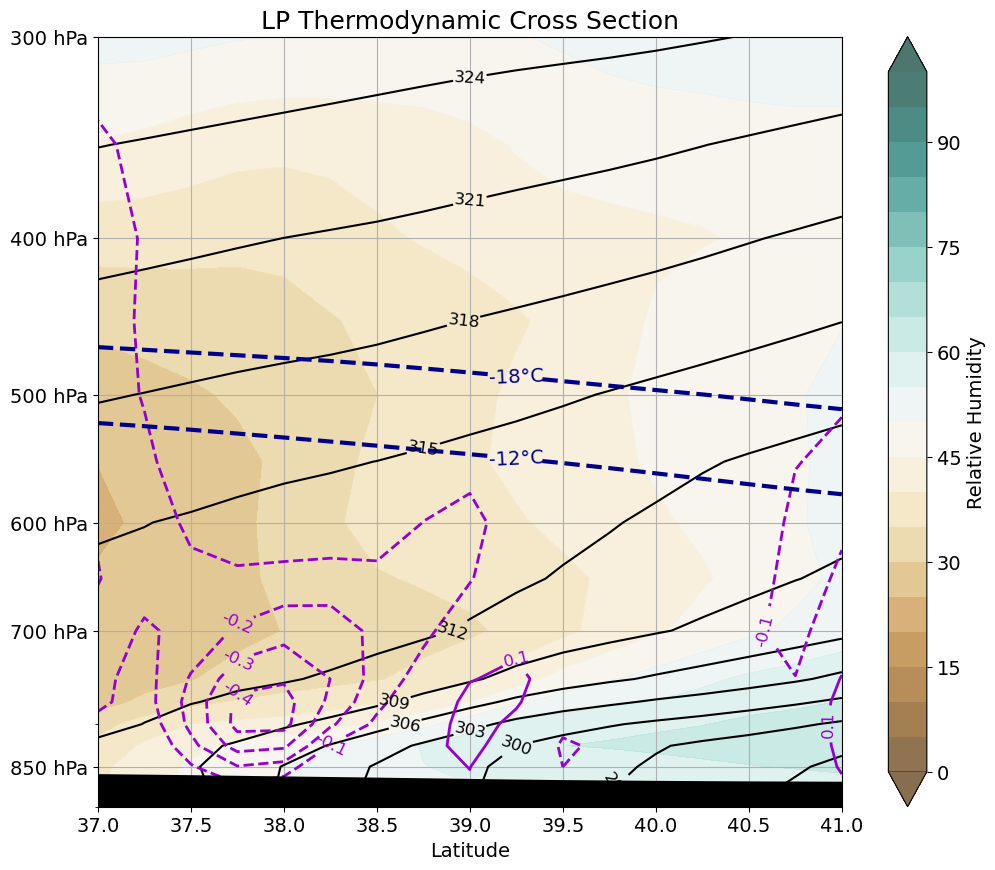

In [33]:
###Plot a vertical cross section for thermo###

#Plot the vertical cross-section#
fig, ax = plt.subplots(figsize=(12, 10))

#Theta contours#
cf = ax.contour(CS_thetaE_LP['latitude'], CS_thetaE_LP['pressure_level'], CS_thetaE_LP['theta_E'], 
                levels=40, colors='black', linewidths=1.5)  # Theta
ax.clabel(cf, inline=True, fontsize=12, fmt='%1.0f') 

#Omega contours#
omega_levels_pos = np.arange(0.1, 1.1, 0.1) 
omega_levels_neg = np.arange(-1.1, 0, 0.1) 

cf2_pos = ax.contour(CS_w_LP['latitude'], CS_w_LP['pressure_level'], CS_w_LP['w_LP_l0'], 
                 levels=omega_levels_pos, colors="darkviolet", extend="both", linewidths=2, alpha=1)  
ax.clabel(cf2_pos, inline=True, fontsize=12, fmt='%1.1f') 

cf2_neg = ax.contour(CS_w_LP['latitude'], CS_w_LP['pressure_level'], CS_w_LP['w_LP_l0'], 
                 levels=omega_levels_neg, colors="darkviolet", extend="both", linewidths=2, alpha=1)  
ax.clabel(cf2_neg, inline=True, fontsize=12, fmt='%1.1f') 

#DGZ contours#
dgz_levels = [-18, -12]  
temperature_c = CS_t_LP['t_LP_l0'] - 273.15  #Kelvin to Celsius

cf_dgz = ax.contour(
    CS_w_LP['latitude'], 
    CS_w_LP['pressure_level'], 
    temperature_c, 
    levels=dgz_levels,  #Only -12°C and -18°C
    colors='darkblue',  
    linestyles='dashed', 
    linewidths=3
)
ax.clabel(cf_dgz, fmt={-12: "-12°C", -18: "-18°C"}, fontsize=14, colors='darkblue')

#Plotting relative humidity
cf_rh = ax.contourf(
    CS_rh_LP['latitude'], 
    CS_rh_LP['pressure_level'], 
    CS_rh_LP['rh_LP_l0'], 
    levels=np.arange(0, 105, 5),  
    cmap="BrBG",  
    extend="both",
    alpha=0.7  
)

#Ground pressure mask#
ground_press = CS_press_LP/100 - 150
ax.plot(ground_press.latitude, ground_press, color='black', linewidth=3, zorder=10, label="Surface")

ax.fill_between(
    ground_press.latitude, ground_press, 1000,  
    color='black', alpha=1, zorder=10, label="Below Surface"
)

##Configure plot##

#Set the y-axis to logarithmic scale#
ax.set_yscale('log')
custom_ticks = [850, 700, 600, 500, 400, 300]  #Pressure levels to match Tropical Tidbits
ax.set_yticks(custom_ticks)
ax.set_yticklabels([f"{tick} hPa" for tick in custom_ticks])  

#Increase tick size#
ax.tick_params(axis='both', which='major', labelsize=12) 
ax.set_yticklabels([f"{tick} hPa" for tick in custom_ticks], fontsize=14)  
ax.set_xticklabels(ax.get_xticks(), fontsize=14)  

# Adjust the y-axis limits
ax.set_ylim(900, 300)  
cb = fig.colorbar(cf_rh, orientation='vertical', pad=0.05)
ax.set_xlabel('Latitude', fontsize=14)
cb.ax.tick_params(labelsize=14)  
cb.set_label('Relative Humidity', fontsize=14)  
#ax.set_ylabel('Pressure Levels ', fontsize=14)
ax.set_title('LP Thermodynamic Cross Section', fontsize=18)
ax.grid(True)

#fig.savefig("CS_LP_Thermo_ThetaE_REV.png", bbox_inches='tight', dpi=300)

plt.show()

In [13]:
# ###Add a fgen calculation###

# #Lats and lons#
# lats = t_HP_l0['t_HP_l0'].latitude.values
# lons = t_HP_l0['t_HP_l0'].longitude.values
# dx, dy = mpcalc.lat_lon_grid_deltas(lons, lats)

# #Convert data to MetPy units#
# #pressure_org = mslpraw_df['MSLPraw_HP_l0'].values * units.hPa
# #pressure = pressure_org[:, :41]
# temperature = t_HP_l0['t_HP_l0'].values * units.degK   #Can also do K
# #dewpoint = sdews_raw_df[data_sel_d].values * units.degK
# u_wind = u_HP_l0['u_HP_l0'].values * units('m/s')
# v_wind = v_HP_l0['v_HP_l0'].values * units('m/s')
# level = 850

# #Convert temperature to potential temperature and equivalent potential temperature#
# theta = theta_HP_l0.copy()

# # thetaE = mpcalc.equivalent_potential_temperature(level * units.hPa, temperature, dewpoint)
# # thetaE_xr = xr.DataArray(thetaE, coords={'latitude': lats, 'longitude': lons}, dims=['latitude', 'longitude'])

# #Calculate the frontogenesis#
# frontogenesis_o = mpcalc.frontogenesis(theta, u_wind, v_wind, dx=dx, dy=dy)
# frontogenesis = frontogenesis_o * 1e9

# # frontogenesis_o2 = mpcalc.frontogenesis(thetaE_xr, u_wind, v_wind, dx=dx, dy=dy)
# # frontogenesis2 = frontogenesis_o2 * 1e9

# #Smooth the fields since they are noisy#
# frontogenesiss = mpcalc.smooth_gaussian(frontogenesis,15)
# #frontogenesiss2 = mpcalc.smooth_gaussian(frontogenesis2,15)

# np.nanmin(frontogenesiss), np.nanmax(frontogenesiss)